Code for Final Project by Hannah Beatty. Each portion of the assignment is broken down into individual cells.

In [75]:
# imports for full file
# Core packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    RFE, SelectFromModel
)
from sklearn.exceptions import ConvergenceWarning

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Misc
from itertools import product

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [76]:
# some globally used functions

def seed_everything(seed: int = 42):
    import os
    import random
    import numpy as np
    import torch

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


# Compute metrics
def accuracy(tn, fp, fn, tp):
    return (tp + tn) / (tp + tn + fp + fn)

def sensitivity(tp, fn):
    return tp / (tp + fn)  # a.k.a. recall, true positive rate

def specificity(tn, fp):
    return tn / (tn + fp)  # true negative rate

In [77]:
'''
The spam dataset contains 58 columns: the first 57 columns are features, and the last column is
the class label denoting whether the e-mail was considered spam (1) or not (0). Split the data into
a train set and a test set.

'''

# preprocessing data
column_names = [f'feature_{i+1}' for i in range(57)] + ['label']
data = pd.read_csv("spambase_data.csv", names=column_names)
data.dropna()

X = data.drop("label", axis=1)
y = data["label"]

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# standard scaling after the split to prevent data leakage with scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
'''
Train the following three classifiers: logistic regression with elastic net regularization, SVM,
and MLP with one or two hidden layers, and show the accuracy, sensitivity, and specificity of
the classifiers. You need to use cross validation to determine hyper-parameters. You cannot
use the MLP module in sklearn, but use PyTorch to build and train MLPs.
'''

# first model: logistic regression with elastic net regularization

lrm = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, n_jobs=1, random_state=42)

# param grid for grid cv to find best params
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

grid_lrm = GridSearchCV(lrm, param_grid_logreg, cv=5, scoring='accuracy')
grid_lrm.fit(X_train_scaled, y_train)

# train logistic regression model using the best parameters
best_lrm = grid_lrm.best_estimator_
y_pred_lrm = best_lrm.predict(X_test_scaled)

print(grid_lrm.best_params_)


KeyboardInterrupt: 

In [ ]:
# second model - SVM
svm = SVC()

param_grid_svm = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
]

grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)

# train model based on best parameters
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print(grid_svm.best_params_)



{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# third model - MLP

SEED = 42
seed_everything(SEED)

# mlp class
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Grid of hyperparameters to search
hidden_layer_sizes = [(32, 16), (64, 32), (128, 64)]
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0, 1e-4, 1e-5]

# Prepare data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store best result
best_score = 0
best_hparams = None

# Grid search loop
for (hidden1, hidden2), lr, wd in product(hidden_layer_sizes, learning_rates, weight_decays):
    fold_scores = []

    for train_idx, val_idx in kf.split(X_train_tensor):
        seed_everything(SEED)
        model = MLP(X_train_tensor.shape[1], hidden1, hidden2)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.BCEWithLogitsLoss()

        X_train_fold = X_train_tensor[train_idx]
        y_train_fold = y_train_tensor[train_idx]
        X_val_fold = X_train_tensor[val_idx]
        y_val_fold = y_train_tensor[val_idx]

        model.train()
        for epoch in range(20):  # modest number of epochs for CV
            optimizer.zero_grad()
            output = model(X_train_fold).squeeze()
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(X_val_fold).squeeze()
            val_probs = torch.sigmoid(val_output)
            val_preds = (val_probs > 0.5).float()
            acc = (val_preds == y_val_fold).float().mean().item()
            fold_scores.append(acc)

    avg_score = sum(fold_scores) / len(fold_scores)

    if avg_score > best_score:
        best_score = avg_score
        best_hparams = (hidden1, hidden2, lr, wd)

# Train final model on full train set with best hyperparams
best_hidden1, best_hidden2, best_lr, best_wd = best_hparams
seed_everything(SEED)
best_mlp = MLP(X_train_tensor.shape[1], best_hidden1, best_hidden2)
optimizer = optim.Adam(best_mlp.parameters(), lr=best_lr, weight_decay=best_wd)
criterion = nn.BCEWithLogitsLoss()

best_mlp.train()
for epoch in range(180):
    optimizer.zero_grad()
    output = best_mlp(X_train_tensor).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict on test set
best_mlp.eval()
with torch.no_grad():
    test_output = best_mlp(X_test_tensor).squeeze()
    test_probs = torch.sigmoid(test_output)
    y_pred_mlp = (test_probs > 0.5).float()

print(f"\nBest hyperparameters: hidden=({best_hidden1}, {best_hidden2}), lr={best_lr}, weight_decay={best_wd}")


Best hyperparameters: hidden=(128, 64), lr=0.01, weight_decay=0.0001



Statistics for LRM: 
Accuracy   : 0.9305
Sensitivity: 0.9008
Specificity: 0.9498

Statistics for SVM: 
Accuracy   : 0.9207
Sensitivity: 0.8815
Specificity: 0.9462

Statistics for MLP: 
Accuracy   : 0.9294
Sensitivity: 0.9036
Specificity: 0.9462


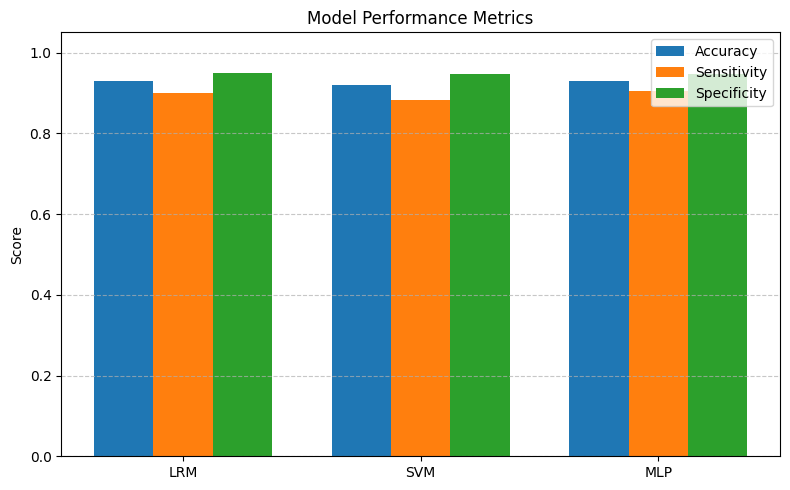

In [ ]:
"""
Show the accuracy, sensitivity, and specificity of the classifiers.
"""

#convert mlp tensors to numpy arrays to use metrics
y_pred_mlp_np = y_pred_mlp.cpu().numpy()
y_test_mlp_np = y_test_tensor.cpu().numpy()

tn_mlp, fp_mlp, fn_mlp, tp_mlp = confusion_matrix(y_test_mlp_np, y_pred_mlp_np).ravel()
tn_lrm, fp_lrm, fn_lrm, tp_lrm = confusion_matrix(y_test, y_pred_lrm).ravel()
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_test, y_pred_svm).ravel()

# Print results
print("\nStatistics for LRM: ")
print(f"Accuracy   : {accuracy(tn_lrm, fp_lrm, fn_lrm, tp_lrm):.4f}")
print(f"Sensitivity: {sensitivity(tp_lrm, fn_lrm):.4f}")
print(f"Specificity: {specificity(tn_lrm, fp_lrm):.4f}")

print("\nStatistics for SVM: ")
print(f"Accuracy   : {accuracy(tn_svm, fp_svm, fn_svm, tp_svm):.4f}")
print(f"Sensitivity: {sensitivity(tp_svm, fn_svm):.4f}")
print(f"Specificity: {specificity(tn_svm, fp_svm):.4f}")

print("\nStatistics for MLP: ")
print(f"Accuracy   : {accuracy(tn_mlp, fp_mlp, fn_mlp, tp_mlp):.4f}")
print(f"Sensitivity: {sensitivity(tp_mlp, fn_mlp):.4f}")
print(f"Specificity: {specificity(tn_mlp, fp_mlp):.4f}")

# Labels
models = ['LRM', 'SVM', 'MLP']

# Metrics per model
accuracies = [
    accuracy(tn_lrm, fp_lrm, fn_lrm, tp_lrm),
    accuracy(tn_svm, fp_svm, fn_svm, tp_svm),
    accuracy(tn_mlp, fp_mlp, fn_mlp, tp_mlp)
]

sensitivities = [
    sensitivity(tp_lrm, fn_lrm),
    sensitivity(tp_svm, fn_svm),
    sensitivity(tp_mlp, fn_mlp)
]

specificities = [
    specificity(tn_lrm, fp_lrm),
    specificity(tn_svm, fp_svm),
    specificity(tn_mlp, fp_mlp)
]

# Set width of each bar
bar_width = 0.25
x = np.arange(len(models))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x, accuracies, width=bar_width, label='Accuracy')
plt.bar(x + bar_width, sensitivities, width=bar_width, label='Sensitivity')
plt.bar(x + 2*bar_width, specificities, width=bar_width, label='Specificity')

# Labels & formatting
plt.xticks(x + bar_width, models)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
'''
Add n fake features to the data. The values of each feature can be generated using a normal
random variable with zero mean and unit variance. Vary n from 10, 100, 200
'''


# Add fake features to entire dataset, THEN split
def add_fake_features(X, n):
    fake = np.random.normal(0, 1, size=(X.shape[0], n))
    return np.hstack((X, fake))

# Create datasets with fake features (before splitting)
X1_fake = add_fake_features(X, 10)
X2_fake = add_fake_features(X, 100)
X3_fake = add_fake_features(X, 200)

# Now split each one into train/test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_fake, y, test_size=0.2, stratify=y, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_fake, y, test_size=0.2, stratify=y, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_fake, y, test_size=0.2, stratify=y, random_state=42)

# Scale each set independently
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

X3_train_scaled = scaler3.fit_transform(X3_train)
X3_test_scaled = scaler3.transform(X3_test)



In [ ]:
'''
Repeat what described in part 1. Plot accuracy, sensitivity, and specificity versus n.
'''

# first, lrm models for each n = 10, 100, 200

# define grid (same as before)
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Data and labels indexed by n
data_by_n = {
    10: (X1_train_scaled, X1_test_scaled, y1_train, y1_test),
    100: (X2_train_scaled, X2_test_scaled, y2_train, y2_test),
    200: (X3_train_scaled, X3_test_scaled, y3_train, y3_test)
}

# Store results
best_lrms = {}
y_preds = {}

for n, (X_train, X_test, y_train, y_test) in data_by_n.items():
    print(f"Training LRM for n={n}...")

    lrm = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )
    
    grid = GridSearchCV(
        lrm,
        param_grid_logreg,
        cv=5,
        scoring='accuracy',
        n_jobs=-1  # Parallelize the grid search
    )
    
    grid.fit(X_train, y_train)
    best_lrm = grid.best_estimator_
    y_pred = best_lrm.predict(X_test)
    print(f"hyperparameters for n={n}: ", grid.best_params_)
    best_lrms[n] = best_lrm
    y_preds[n] = y_pred

Training LRM for n=10...
hyperparameters for n=10:  {'C': 1, 'l1_ratio': 0.5}
Training LRM for n=100...
hyperparameters for n=100:  {'C': 0.1, 'l1_ratio': 0.9}
Training LRM for n=200...
hyperparameters for n=200:  {'C': 0.1, 'l1_ratio': 0.9}



LRM Metrics for n = 10
Accuracy   : 0.9316
Sensitivity: 0.8981
Specificity: 0.9534

LRM Metrics for n = 100
Accuracy   : 0.9229
Sensitivity: 0.8871
Specificity: 0.9462

LRM Metrics for n = 200
Accuracy   : 0.9186
Sensitivity: 0.8705
Specificity: 0.9498


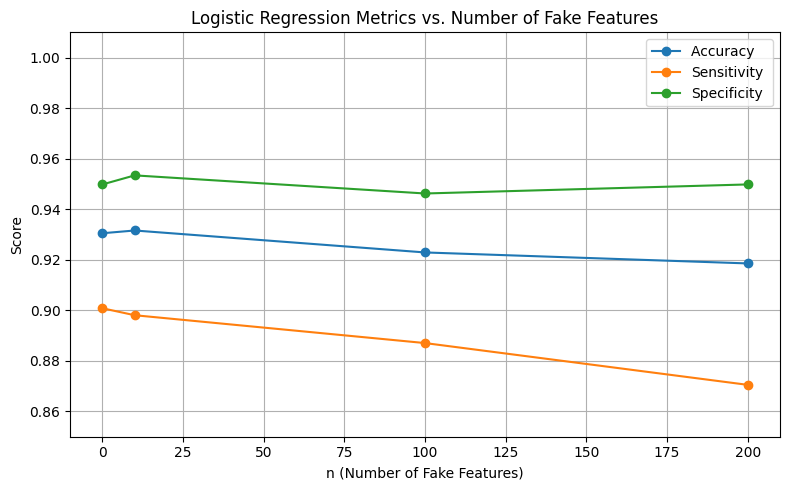

In [ ]:
# accuracy, sensitivity, specificity versus n for logistic regression models

# Store metrics by n
metric_results = {}

# Note that I am adding n = 0 (the original lrm with no fake features) for fair comparison

metric_results[0] = {
    "Accuracy   ": accuracy(tn_lrm, fp_lrm, fn_lrm, tp_lrm),
    "Sensitivity": sensitivity(tp_lrm, fn_lrm),
    "Specificity": specificity(tn_lrm, fp_lrm)
}

for n in [10, 100, 200]:
    y_test = data_by_n[n][3]
    y_pred = y_preds[n]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metric_results[n] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"\nLRM Metrics for n = {n}")
    for key, value in metric_results[n].items():
        print(f"{key}: {value:.4f}")

# plot over n: all on same graph

n_values = sorted(metric_results.keys())
metrics = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics:
    values = [metric_results[n][metric] for n in n_values]
    plt.plot(n_values, values, marker='o', label=metric)

plt.title("Logistic Regression Metrics vs. Number of Fake Features")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# svm models for each n = 10, 100, 200
# use same (X1, y1), (X2, y2), (X3, y3) as the lrm tests

#filter out convergence for one of the really really inefficient combinations

# SVM hyperparameter grid
param_grid_svm = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
]

# Reuse the same data_by_n dictionary
# {n: (X_train_scaled, X_test_scaled, y_train, y_test)}

best_svms = {}
y_preds_svm = {}

for n, (X_train, X_test, y_train, y_test) in data_by_n.items():
    print(f"Training SVM for n={n}...")

    svm = SVC(max_iter=50000, tol=1e-3)  # speed optimization

    grid = GridSearchCV(
        svm,
        param_grid_svm,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )


    grid.fit(X_train, y_train)
    best_svm = grid.best_estimator_
    y_pred = best_svm.predict(X_test)
    print(f"best hyperparameters for n={n}: ", grid.best_params_)
    best_svms[n] = best_svm
    y_preds_svm[n] = y_pred


Training SVM for n=10...
best hyperparameters for n=10:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Training SVM for n=100...
best hyperparameters for n=100:  {'C': 1, 'kernel': 'linear'}
Training SVM for n=200...
best hyperparameters for n=200:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}



SVM Metrics for n = 10
Accuracy   : 0.9251
Sensitivity: 0.8760
Specificity: 0.9570

SVM Metrics for n = 100
Accuracy   : 0.9273
Sensitivity: 0.8926
Specificity: 0.9498

SVM Metrics for n = 200
Accuracy   : 0.9034
Sensitivity: 0.8540
Specificity: 0.9355


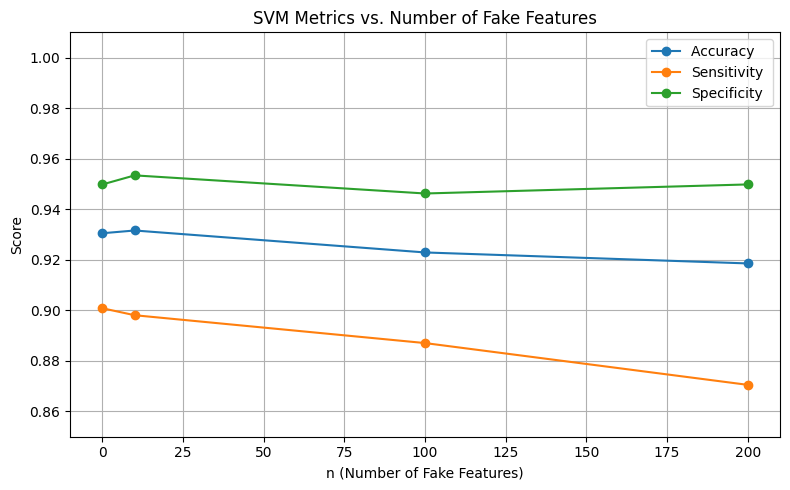

In [ ]:
# accuracy, sensitivity, specificity versus n for svm models

# Store metrics by n
metric_results2 = {}

# Note that I am adding n = 0 (the original svm with no fake features) for fair comparison

metric_results2[0] = {
    "Accuracy   ": accuracy(tn_svm, fp_svm, fn_svm, tp_svm),
    "Sensitivity": sensitivity(tp_svm, fn_svm),
    "Specificity": specificity(tn_svm, fp_svm)
}

for n in [10, 100, 200]:
    y_test = data_by_n[n][3]
    y_pred = y_preds_svm[n]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metric_results2[n] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"\nSVM Metrics for n = {n}")
    for key, value in metric_results2[n].items():
        print(f"{key}: {value:.4f}")

# plot over n: all on same graph

n_values_2 = sorted(metric_results2.keys())
metrics2 = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics2:
    values2 = [metric_results[n][metric] for n in n_values]
    plt.plot(n_values, values2, marker='o', label=metric)

plt.title("SVM Metrics vs. Number of Fake Features")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# mlp models for each n = 10, 100, 200

SEED = 42
seed_everything(SEED)

# use same (X1, y1), (X2, y2), (X3, y3) as the lrm and svm tests

best_mlps = {}
y_preds_mlp = {}

# hyper params to test + kf definition
hidden_layer_sizes = [(32, 16), (64, 32), (128, 64)]
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0, 1e-4, 1e-5]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# use the mlp class i made earlier 

# use a loop to not be repetitive with code def
for n, (X_train_np, X_test_np, y_train_np, y_test_np) in data_by_n.items():
    print(f"Training MLP for n={n}")
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.float32)

    best_score = 0
    best_hparams = None

    for (hidden1, hidden2), lr, wd in product(hidden_layer_sizes, learning_rates, weight_decays):
        fold_scores = []

        for train_idx, val_idx in kf.split(X_train_tensor):
            seed_everything(SEED)
            model = MLP(X_train_tensor.shape[1], hidden1, hidden2)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.BCEWithLogitsLoss()

            X_train_fold = X_train_tensor[train_idx]
            y_train_fold = y_train_tensor[train_idx]
            X_val_fold = X_train_tensor[val_idx]
            y_val_fold = y_train_tensor[val_idx]

            model.train()
            for epoch in range(20):
                optimizer.zero_grad()
                output = model(X_train_fold).squeeze()
                loss = criterion(output, y_train_fold)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_fold).squeeze()
                val_probs = torch.sigmoid(val_output)
                val_preds = (val_probs > 0.5).float()
                acc = (val_preds == y_val_fold).float().mean().item()
                fold_scores.append(acc)

        avg_score = sum(fold_scores) / len(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_hparams = (hidden1, hidden2, lr, wd)

    # Final model training with best hyperparams
    best_hidden1, best_hidden2, best_lr, best_wd = best_hparams
    seed_everything(SEED)
    best_mlp = MLP(X_train_tensor.shape[1], best_hidden1, best_hidden2)
    optimizer = optim.Adam(best_mlp.parameters(), lr=best_lr, weight_decay=best_wd)
    criterion = nn.BCEWithLogitsLoss()

    best_mlp.train()
    for epoch in range(90):
        optimizer.zero_grad()
        output = best_mlp(X_train_tensor).squeeze()
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    best_mlp.eval()
    with torch.no_grad():
        test_output = best_mlp(X_test_tensor).squeeze()
        test_probs = torch.sigmoid(test_output)
        y_pred_mlp = (test_probs > 0.5).float()

    best_mlps[n] = best_mlp
    y_preds_mlp[n] = y_pred_mlp

    print(f"Best hyperparams for n={n}: hidden=({best_hidden1}, {best_hidden2}), lr={best_lr}, weight_decay={best_wd}\n")

Training MLP for n=10
Best hyperparams for n=10: hidden=(128, 64), lr=0.01, weight_decay=0

Training MLP for n=100
Best hyperparams for n=100: hidden=(32, 16), lr=0.01, weight_decay=1e-05

Training MLP for n=200
Best hyperparams for n=200: hidden=(32, 16), lr=0.01, weight_decay=0.0001



MLP Metrics for n = 10
Accuracy   : 0.9251
Sensitivity: 0.8760
Specificity: 0.9570
 
MLP Metrics for n = 100
Accuracy   : 0.9273
Sensitivity: 0.8926
Specificity: 0.9498
 
MLP Metrics for n = 200
Accuracy   : 0.9034
Sensitivity: 0.8540
Specificity: 0.9355
 


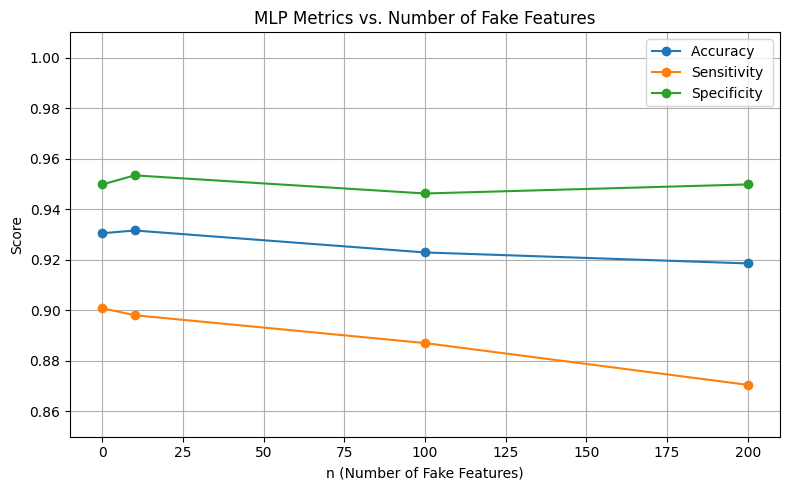

In [ ]:
# accuracy, sensitivity, specificity versus n for mlp models

# Store metrics by n
metric_results3 = {}

# Note that I am adding n = 0 (the original svm with no fake features) for fair comparison

metric_results3[0] = {
    "Accuracy   ": accuracy(tn_mlp, fp_mlp, fn_mlp, tp_mlp),
    "Sensitivity": sensitivity(tp_mlp, fn_mlp),
    "Specificity": specificity(tn_mlp, fp_mlp)
}

for n in [10, 100, 200]:
    y_test = data_by_n[n][3]
    y_pred = y_preds_svm[n]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metric_results3[n] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"MLP Metrics for n = {n}")
    for key, value in metric_results3[n].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# plot over n: all on same graph

import matplotlib.pyplot as plt

n_values_3 = sorted(metric_results3.keys())
metrics3 = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics3:
    values3 = [metric_results[n][metric] for n in n_values]
    plt.plot(n_values, values3, marker='o', label=metric)

plt.title("MLP Metrics vs. Number of Fake Features")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# now, we do feature selection on the train-test split versions of (X1, y!), (X2, y2), (X3, y3)
# use best feature selection we determined earlier


# X0 model - n=0 fake features added (base case)
selector0 = SelectKBest(score_func=f_classif, k=50)
X0_train_selected = selector0.fit_transform(X_train, y_train)
X0_test_selected = selector0.transform(X_test)
scaler0 = StandardScaler()
X0_train_final = scaler0.fit_transform(X0_train_selected)
X0_test_final = scaler0.transform(X0_test_selected)

# X1 model - n=10 fake features added
selector1 = SelectKBest(score_func=f_classif, k=50)
X1_train_selected = selector1.fit_transform(X1_train, y1_train)
X1_test_selected = selector1.transform(X1_test)
scaler10 = StandardScaler()
X1_train_final = scaler10.fit_transform(X1_train_selected)
X1_test_final = scaler10.transform(X1_test_selected)

# X2 model - n=100 fake features added
selector2 = SelectKBest(score_func=f_classif, k=50)
X2_train_selected = selector2.fit_transform(X2_train, y2_train)
X2_test_selected = selector2.transform(X2_test)
scaler100 = StandardScaler()
X2_train_final = scaler100.fit_transform(X2_train_selected)
X2_test_final = scaler100.transform(X2_test_selected)

# X3 model - n=200 fake features added
selector3 = SelectKBest(score_func=f_classif, k=50)
X3_train_selected = selector3.fit_transform(X3_train, y3_train)
X3_test_selected = selector3.transform(X3_test)
scaler200 = StandardScaler()
X3_train_final = scaler200.fit_transform(X3_train_selected)
X3_test_final = scaler200.transform(X3_test_selected)   


In [ ]:
'''
Train the three classifiers.
'''

# once again, I will be training three classifiers per n and graph against n. 
# Logistic Regression models for n = 0, 10, 100, 200 (with feature selection)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Use feature-selected and scaled data
data_by_n2 = {
    0: (X0_train_final, X0_test_final, y_train, y_test),
    10: (X1_train_final, X1_test_final, y1_train, y1_test),
    100: (X2_train_final, X2_test_final, y2_train, y2_test),
    200: (X3_train_final, X3_test_final, y3_train, y3_test)
}

# Store results
best_lrms2 = {}
y_preds_lrm2 = {}

for n, (X_train, X_test, y_train, y_test) in data_by_n2.items():
    print(f"Training feature-selected LRM for n={n}...")

    lrm = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )
    
    grid = GridSearchCV(
        lrm,
        param_grid_logreg,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    best_lrm = grid.best_estimator_
    y_pred = best_lrm.predict(X_test)
    print(f"hyperparameters for n={n}: ", grid.best_params_)
    best_lrms2[n] = best_lrm
    y_preds_lrm2[n] = y_pred


Training feature-selected LRM for n=0...
hyperparameters for n=0:  {'C': 10, 'l1_ratio': 0.1}
Training feature-selected LRM for n=10...
hyperparameters for n=10:  {'C': 10, 'l1_ratio': 0.1}
Training feature-selected LRM for n=100...
hyperparameters for n=100:  {'C': 10, 'l1_ratio': 0.1}
Training feature-selected LRM for n=200...
hyperparameters for n=200:  {'C': 10, 'l1_ratio': 0.1}


Feature-Selected LRM Metrics for n = 0
Accuracy   : 0.9305
Sensitivity: 0.8898
Specificity: 0.9570
 
Feature-Selected LRM Metrics for n = 10
Accuracy   : 0.9305
Sensitivity: 0.8898
Specificity: 0.9570
 
Feature-Selected LRM Metrics for n = 100
Accuracy   : 0.9305
Sensitivity: 0.8898
Specificity: 0.9570
 
Feature-Selected LRM Metrics for n = 200
Accuracy   : 0.9305
Sensitivity: 0.8898
Specificity: 0.9570
 


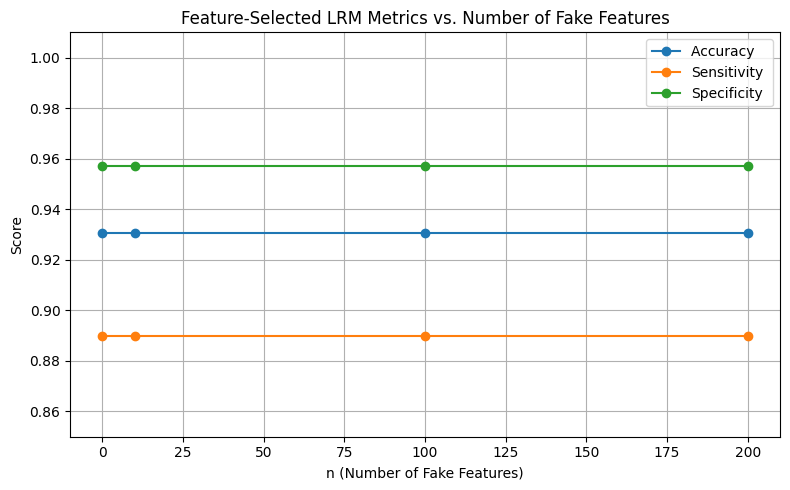

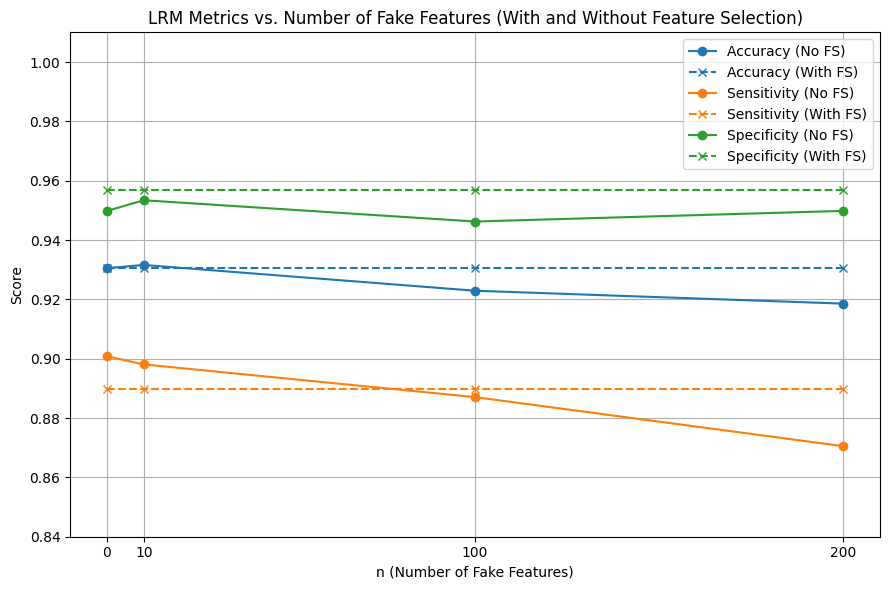

In [ ]:
# accuracy, sensitivity, specificity versus n for FEATURE SELECTED lrm models

# Store metrics by n
metric_results4 = {}

# Note that I am adding n = 0 (the original svm with no fake features) for fair comparison

for n in [0, 10, 100, 200]:
    y_test = data_by_n2[n][3]
    y_pred = y_preds_lrm2[n]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metric_results4[n] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"Feature-Selected LRM Metrics for n = {n}")
    for key, value in metric_results4[n].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# plot over n: all on same graph

n_values_4 = sorted(metric_results4.keys())
metrics4 = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics4:
    values4 = [metric_results4[n][metric] for n in n_values_4]
    plt.plot(n_values_4, values4, marker='o', label=metric)

plt.title("Feature-Selected LRM Metrics vs. Number of Fake Features")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plot of feature selected vs non-feature selected with n-fake features added

n_values_all = [0, 10, 100, 200]  # Include n = 0 for No FS
n_values_fs = [0, 10, 100, 200]      # FS was only applied on fake-feature data

metrics = ["Accuracy   ", "Sensitivity", "Specificity"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(9, 6))

for i, metric in enumerate(metrics):
    # y-values
    values_raw = [metric_results[n][metric] for n in n_values_all]
    values_fs = [metric_results4[n][metric] for n in n_values_fs]

    # Plot both
    plt.plot(n_values_all, values_raw, marker='o', label=f"{metric.strip()} (No FS)", color=colors[i])
    plt.plot(n_values_fs, values_fs, marker='x', linestyle='--', label=f"{metric.strip()} (With FS)", color=colors[i])

plt.title("LRM Metrics vs. Number of Fake Features (With and Without Feature Selection)")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.84, 1.01)
plt.xticks(n_values_all)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# now for svm models 

# svm models for each n = 10, 100, 200
# use same (X1, y1), (X2, y2), (X3, y3) feature selected from LRM tests
# SVM hyperparameter grid
param_grid_svm = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
]

# Updated data_by_n for feature-selected datasets
data_by_n_svm_fs = {
    0: (X0_train_final, X0_test_final, y_train, y_test),
    10: (X1_train_final, X1_test_final, y1_train, y1_test),
    100: (X2_train_final, X2_test_final, y2_train, y2_test),
    200: (X3_train_final, X3_test_final, y3_train, y3_test)
}

# Store best models and predictions
best_svms_fs = {}
y_preds_svm_fs = {}

for n, (X_train, X_test, y_train, y_test) in data_by_n_svm_fs.items():
    print(f"Training Feature-Selected SVM for n={n}...")

    svm = SVC(max_iter=50000, tol=1e-3)

    grid = GridSearchCV(
        svm,
        param_grid_svm,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_svm = grid.best_estimator_
    y_pred = best_svm.predict(X_test)
    print(f"Best hyperparameters for n={n}: ", grid.best_params_)
    best_svms_fs[n] = best_svm
    y_preds_svm_fs[n] = y_pred


Training Feature-Selected SVM for n=0...
Best hyperparameters for n=0:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Training Feature-Selected SVM for n=10...
Best hyperparameters for n=10:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Training Feature-Selected SVM for n=100...
Best hyperparameters for n=100:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Training Feature-Selected SVM for n=200...
Best hyperparameters for n=200:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Feature-Selected SVM Metrics for n = 0
Accuracy   : 0.9121
Sensitivity: 0.8623
Specificity: 0.9444
 
Feature-Selected SVM Metrics for n = 10
Accuracy   : 0.9121
Sensitivity: 0.8623
Specificity: 0.9444
 
Feature-Selected SVM Metrics for n = 100
Accuracy   : 0.9121
Sensitivity: 0.8623
Specificity: 0.9444
 
Feature-Selected SVM Metrics for n = 200
Accuracy   : 0.9121
Sensitivity: 0.8623
Specificity: 0.9444
 


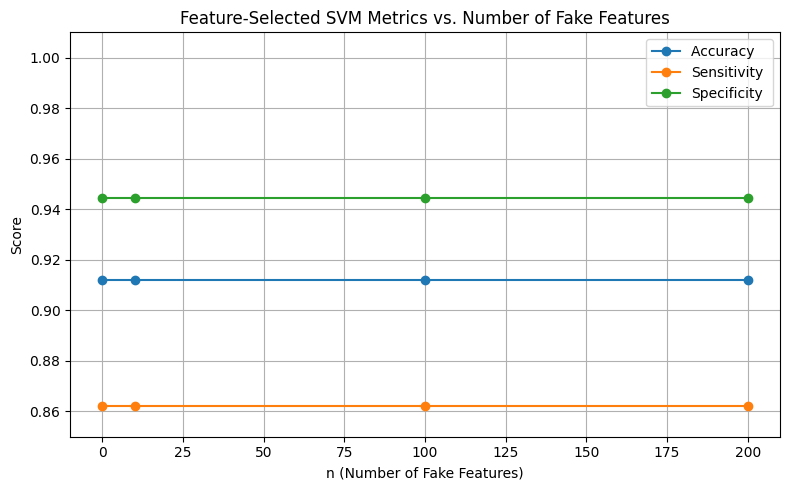

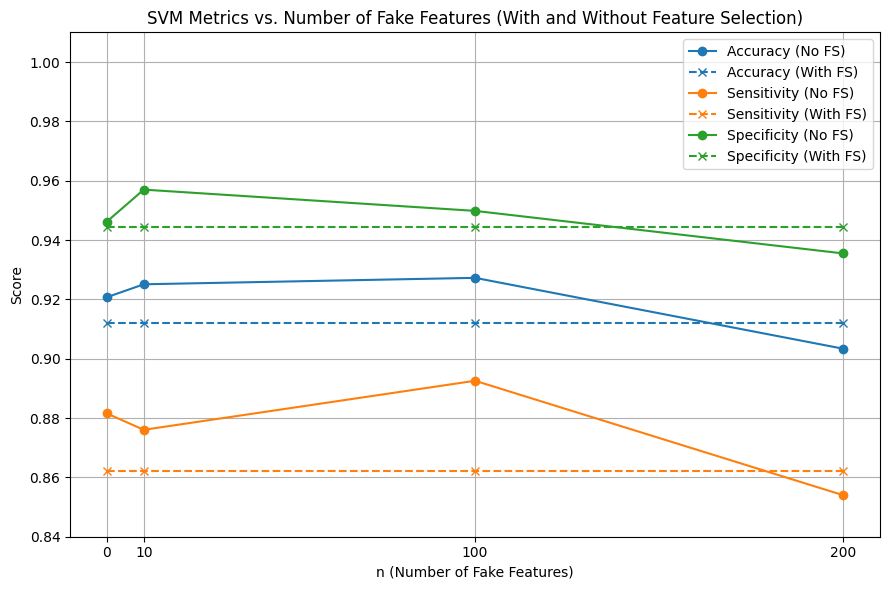

In [ ]:
# accuracy, sensitivity, specificity versus n for FEATURE SELECTED svm models vs normal

# Store metrics by n
metric_results5 = {}

# Note that I am adding n = 0 (the original svm with no fake features) for fair comparison

for n in [0, 10, 100, 200]:
    y_test = data_by_n2[n][3]
    y_pred = y_preds_svm_fs[n]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metric_results5[n] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"Feature-Selected SVM Metrics for n = {n}")
    for key, value in metric_results5[n].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# plot over n: all on same graph

n_values_5 = sorted(metric_results5.keys())
metrics5 = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics5:
    values5 = [metric_results5[n][metric] for n in n_values_5]
    plt.plot(n_values_5, values5, marker='o', label=metric)

plt.title("Feature-Selected SVM Metrics vs. Number of Fake Features")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plot of feature selected vs non-feature selected with n-fake features added

n_values_all = [0, 10, 100, 200]  # Include n = 0 for No FS
n_values_fs = [0, 10, 100, 200]      # FS was only applied on fake-feature data

metrics = ["Accuracy   ", "Sensitivity", "Specificity"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(9, 6))

for i, metric in enumerate(metrics):
    # y-values
    values_raw = [metric_results2[n][metric] for n in n_values_all]
    values_fs = [metric_results5[n][metric] for n in n_values_fs]

    # Plot both
    plt.plot(n_values_all, values_raw, marker='o', label=f"{metric.strip()} (No FS)", color=colors[i])
    plt.plot(n_values_fs, values_fs, marker='x', linestyle='--', label=f"{metric.strip()} (With FS)", color=colors[i])

plt.title("SVM Metrics vs. Number of Fake Features (With and Without Feature Selection)")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.84, 1.01)
plt.xticks(n_values_all)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# now for mlp models

# seed for reproducability
SEED = 42
seed_everything(SEED)

best_mlps_fs = {}
y_preds_mlp_fs = {}

# Hyperparameter grids
hidden_layer_sizes = [(32, 16), (64, 32), (128, 64)]
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0, 1e-4, 1e-5]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Updated data_by_n for feature-selected datasets
data_by_n_mlp_fs = {
    0: (X0_train_final, X0_test_final, y_train, y_test),
    10: (X1_train_final, X1_test_final, y1_train, y1_test),
    100: (X2_train_final, X2_test_final, y2_train, y2_test),
    200: (X3_train_final, X3_test_final, y3_train, y3_test)
}

for n, (X_train_np, X_test_np, y_train_np, y_test_np) in data_by_n_mlp_fs.items():
    print(f"Training Feature-Selected MLP for n={n}")
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.float32)

    best_score = 0
    best_hparams = None

    for (hidden1, hidden2), lr, wd in product(hidden_layer_sizes, learning_rates, weight_decays):
        fold_scores = []

        for train_idx, val_idx in kf.split(X_train_tensor):
            seed_everything(SEED)
            model = MLP(X_train_tensor.shape[1], hidden1, hidden2)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.BCEWithLogitsLoss()

            X_train_fold = X_train_tensor[train_idx]
            y_train_fold = y_train_tensor[train_idx]
            X_val_fold = X_train_tensor[val_idx]
            y_val_fold = y_train_tensor[val_idx]

            model.train()
            for epoch in range(20):
                optimizer.zero_grad()
                output = model(X_train_fold).squeeze()
                loss = criterion(output, y_train_fold)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_fold).squeeze()
                val_probs = torch.sigmoid(val_output)
                val_preds = (val_probs > 0.5).float()
                acc = (val_preds == y_val_fold).float().mean().item()
                fold_scores.append(acc)

        avg_score = sum(fold_scores) / len(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_hparams = (hidden1, hidden2, lr, wd)

    # Final model training with best hyperparams
    best_hidden1, best_hidden2, best_lr, best_wd = best_hparams
    seed_everything(SEED)
    best_mlp = MLP(X_train_tensor.shape[1], best_hidden1, best_hidden2)
    optimizer = optim.Adam(best_mlp.parameters(), lr=best_lr, weight_decay=best_wd)
    criterion = nn.BCEWithLogitsLoss()

    best_mlp.train()
    for epoch in range(90):
        optimizer.zero_grad()
        output = best_mlp(X_train_tensor).squeeze()
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    best_mlp.eval()
    with torch.no_grad():
        test_output = best_mlp(X_test_tensor).squeeze()
        test_probs = torch.sigmoid(test_output)
        y_pred_mlp = (test_probs > 0.5).float()

    best_mlps_fs[n] = best_mlp
    y_preds_mlp_fs[n] = y_pred_mlp

    print(f"Best hyperparams for n={n}: hidden=({best_hidden1}, {best_hidden2}), lr={best_lr}, weight_decay={best_wd}\n")


Training Feature-Selected MLP for n=0
Best hyperparams for n=0: hidden=(128, 64), lr=0.01, weight_decay=0

Training Feature-Selected MLP for n=10
Best hyperparams for n=10: hidden=(128, 64), lr=0.01, weight_decay=0

Training Feature-Selected MLP for n=100
Best hyperparams for n=100: hidden=(128, 64), lr=0.01, weight_decay=0

Training Feature-Selected MLP for n=200
Best hyperparams for n=200: hidden=(128, 64), lr=0.01, weight_decay=0



Feature-Selected MLP Metrics for n = 0
Accuracy   : 0.9294
Sensitivity: 0.9063
Specificity: 0.9444
 
Feature-Selected MLP Metrics for n = 10
Accuracy   : 0.9294
Sensitivity: 0.9063
Specificity: 0.9444
 
Feature-Selected MLP Metrics for n = 100
Accuracy   : 0.9294
Sensitivity: 0.9063
Specificity: 0.9444
 
Feature-Selected MLP Metrics for n = 200
Accuracy   : 0.9294
Sensitivity: 0.9063
Specificity: 0.9444
 


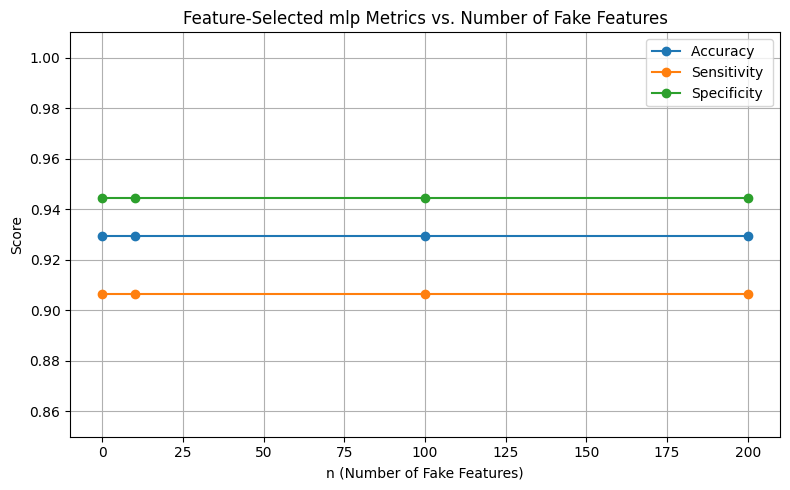

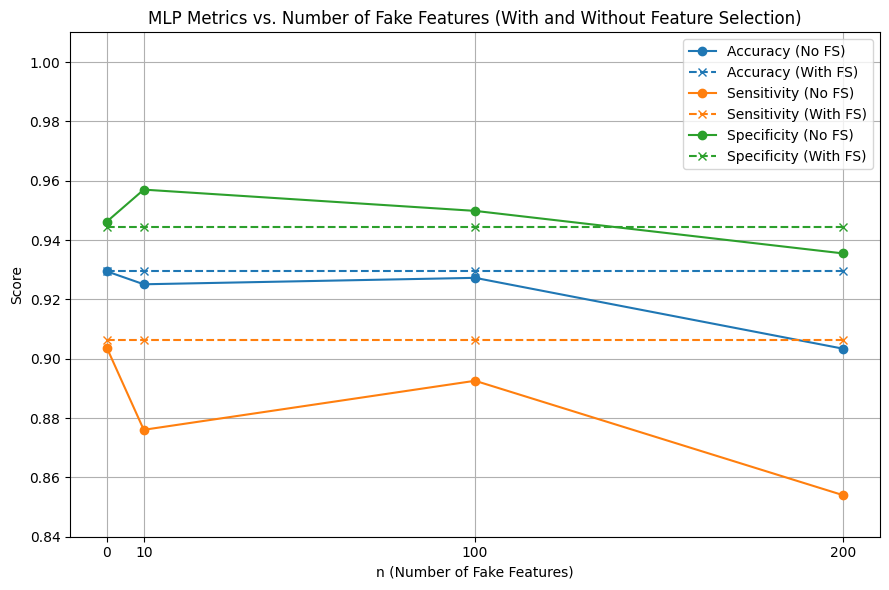

In [ ]:
# accuracy, sensitivity, specificity versus n for FEATURE SELECTED mlp models vs normal

# Store metrics by n
metric_results6 = {}

# Note that I am adding n = 0 (the original mlp with no fake features) for fair comparison

for n in [0, 10, 100, 200]:
    y_test = data_by_n2[n][3]
    y_pred = y_preds_mlp_fs[n]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metric_results6[n] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"Feature-Selected MLP Metrics for n = {n}")
    for key, value in metric_results6[n].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# plot over n: all on same graph

n_values_6 = sorted(metric_results6.keys())
metrics6 = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics:
    values6 = [metric_results6[n][metric] for n in n_values_6]
    plt.plot(n_values_6, values6, marker='o', label=metric)

plt.title("Feature-Selected mlp Metrics vs. Number of Fake Features")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plot of feature selected vs non-feature selected with n-fake features added

n_values_all = [0, 10, 100, 200]  # Include n = 0 for No FS
n_values_fs = [0, 10, 100, 200]      # FS was only applied on fake-feature data

metrics = ["Accuracy   ", "Sensitivity", "Specificity"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(9, 6))

for i, metric in enumerate(metrics):
    # y-values
    values_raw = [metric_results3[n][metric] for n in n_values_all]
    values_fs = [metric_results6[n][metric] for n in n_values_fs]

    # Plot both
    plt.plot(n_values_all, values_raw, marker='o', label=f"{metric.strip()} (No FS)", color=colors[i])
    plt.plot(n_values_fs, values_fs, marker='x', linestyle='--', label=f"{metric.strip()} (With FS)", color=colors[i])

plt.title("MLP Metrics vs. Number of Fake Features (With and Without Feature Selection)")
plt.xlabel("n (Number of Fake Features)")
plt.ylabel("Score")
plt.ylim(0.84, 1.01)
plt.xticks(n_values_all)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Define noise variances to test
noise_variances = [0.001, 0.01, 0.1, 1.0]

# Function to add Gaussian noise to already standardized data
def add_gaussian_noise(X, variance):
    noise = np.random.normal(loc=0.0, scale=np.sqrt(variance), size=X.shape)
    return X + noise

# First, standardize the clean training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Container to hold noisy versions
data_by_noise = {}

for var in noise_variances:
    # Add noise *after* standardization
    X_train_noisy = add_gaussian_noise(X_train_scaled, var)
    X_test_noisy  = add_gaussian_noise(X_test_scaled, var)

    # Save for later model training and evaluation
    data_by_noise[var] = (X_train_noisy, X_test_noisy, y_train, y_test)



In [ ]:
'''
Repeat what described in part 1. Plot accuracy, sensitivity, and specificity versus σ^2
'''

# start with lrm - train four models, one for each noise variance

# Grid
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Store models and predictions
best_lrms_by_noise = {}
y_preds_lrm_by_noise = {}

for var, (X_train, X_test, y_train, y_test) in data_by_noise.items():
    print(f"Training LRM for noise variance = {var}...")

    lrm = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )

    grid = GridSearchCV(
        lrm,
        param_grid_logreg,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_lrm = grid.best_estimator_
    y_pred = best_lrm.predict(X_test)
    print(f"Best hyperparameters for noise variance = {var}: ", grid.best_params_)
    best_lrms_by_noise[var] = best_lrm
    y_preds_lrm_by_noise[var] = (y_test, y_pred)  # Store true and predicted labels

    print(f"Finished training for noise variance = {var}\n")



Training LRM for noise variance = 0.001...
Best hyperparameters for noise variance = 0.001:  {'C': 10, 'l1_ratio': 0.1}
Finished training for noise variance = 0.001

Training LRM for noise variance = 0.01...
Best hyperparameters for noise variance = 0.01:  {'C': 10, 'l1_ratio': 0.1}
Finished training for noise variance = 0.01

Training LRM for noise variance = 0.1...
Best hyperparameters for noise variance = 0.1:  {'C': 1, 'l1_ratio': 0.9}
Finished training for noise variance = 0.1

Training LRM for noise variance = 1.0...
Best hyperparameters for noise variance = 1.0:  {'C': 0.01, 'l1_ratio': 0.1}
Finished training for noise variance = 1.0



LRM Metrics for noise variance = 0.001
Accuracy   : 0.9229
Sensitivity: 0.8788
Specificity: 0.9516
 
LRM Metrics for noise variance = 0.01
Accuracy   : 0.9251
Sensitivity: 0.8953
Specificity: 0.9444
 
LRM Metrics for noise variance = 0.1
Accuracy   : 0.8871
Sensitivity: 0.8347
Specificity: 0.9211
 
LRM Metrics for noise variance = 1.0
Accuracy   : 0.8132
Sensitivity: 0.6887
Specificity: 0.8943
 


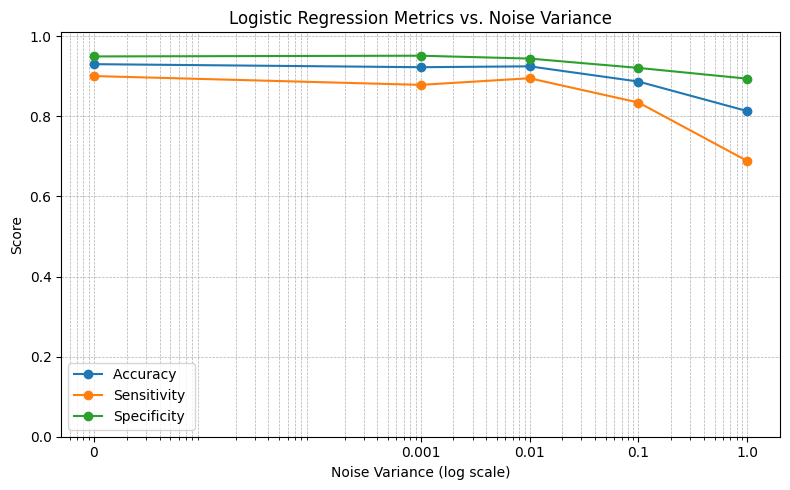

In [ ]:
# Add base case metrics (noise = 0)
metric_results_lrm_noise = {}
metric_results_lrm_noise[0.0] = {
    "Accuracy   ": accuracies[0],
    "Sensitivity": sensitivities[0],
    "Specificity": specificities[0]
}

# Process noisy predictions
for var, (y_true, y_pred) in y_preds_lrm_by_noise.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metric_results_lrm_noise[var] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"LRM Metrics for noise variance = {var}")
    for key, value in metric_results_lrm_noise[var].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# Prepare for plotting
vars_sorted = sorted(metric_results_lrm_noise.keys())
plot_vars = [1e-6 if v == 0.0 else v for v in vars_sorted]
xtick_labels = ['0' if v == 1e-6 else str(v) for v in plot_vars]

metrics = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics:
    values = [metric_results_lrm_noise[0.0 if v == 1e-6 else v][metric] for v in plot_vars]
    plt.plot(plot_vars, values, marker='o', label=metric)

plt.xscale("log")
plt.title("Logistic Regression Metrics vs. Noise Variance")
plt.xlabel("Noise Variance (log scale)")
plt.ylabel("Score")
plt.ylim(0.0, 1.01)
plt.xticks(plot_vars, xtick_labels)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# now for svm
# SVM hyperparameter grid
param_grid_svm = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
]

# Store best models and predictions by noise level
best_svms_by_noise = {}
y_preds_svm_by_noise = {}

for var, (X_train, X_test, y_train, y_test) in sorted(data_by_noise.items()):
    print(f"Training SVM for noise variance = {var}...")

    svm = SVC(max_iter=50000, tol=1e-3)

    grid = GridSearchCV(
        svm,
        param_grid_svm,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_svm = grid.best_estimator_
    y_pred = best_svm.predict(X_test)

    print(f"Best hyperparameters for σ² = {var}: {grid.best_params_}")

    best_svms_by_noise[var] = best_svm
    y_preds_svm_by_noise[var] = (y_test, y_pred)

    print(f"Finished training for σ² = {var}\n")


Training SVM for noise variance = 0.0...
Best hyperparameters for σ² = 0.0: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Finished training for σ² = 0.0

Training SVM for noise variance = 0.001...
Best hyperparameters for σ² = 0.001: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Finished training for σ² = 0.001

Training SVM for noise variance = 0.01...
Best hyperparameters for σ² = 0.01: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Finished training for σ² = 0.01

Training SVM for noise variance = 0.1...
Best hyperparameters for σ² = 0.1: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Finished training for σ² = 0.1

Training SVM for noise variance = 1.0...
Best hyperparameters for σ² = 1.0: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Finished training for σ² = 1.0



SVM Metrics for noise variance = 0.0
Accuracy   : 0.9121
Sensitivity: 0.8623
Specificity: 0.9444
 
SVM Metrics for noise variance = 0.001
Accuracy   : 0.9251
Sensitivity: 0.8788
Specificity: 0.9552
 
SVM Metrics for noise variance = 0.01
Accuracy   : 0.9175
Sensitivity: 0.8678
Specificity: 0.9498
 
SVM Metrics for noise variance = 0.1
Accuracy   : 0.9045
Sensitivity: 0.8375
Specificity: 0.9480
 
SVM Metrics for noise variance = 1.0
Accuracy   : 0.8284
Sensitivity: 0.7052
Specificity: 0.9086
 


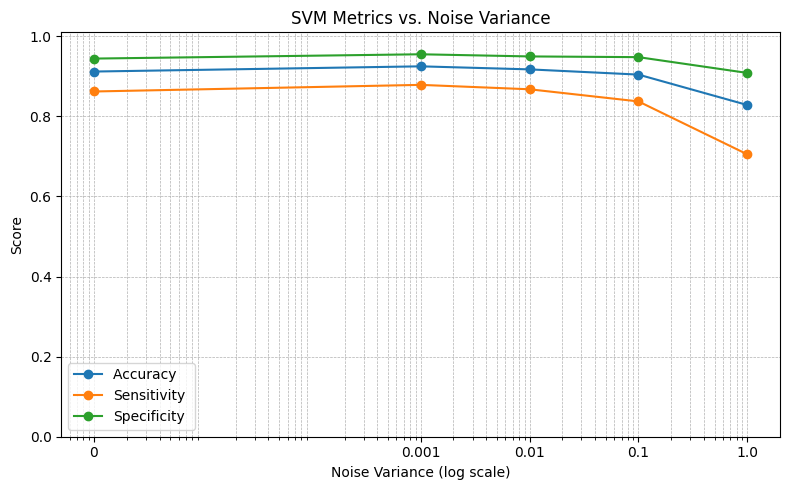

In [ ]:
# svm metrics for each noise variance
# Add base case metrics (noise = 0)
metric_results_svm_noise = {}
metric_results_svm_noise[0.0] = {
    "Accuracy   ": accuracies[1],
    "Sensitivity": sensitivities[1],
    "Specificity": specificities[1]
}

# Process noisy predictions
for var, (y_true, y_pred) in y_preds_svm_by_noise.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metric_results_svm_noise[var] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"SVM Metrics for noise variance = {var}")
    for key, value in metric_results_svm_noise[var].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# Prepare for plotting
vars_sorted = sorted(metric_results_svm_noise.keys())
plot_vars = [1e-6 if v == 0.0 else v for v in vars_sorted]
xtick_labels = ['0' if v == 1e-6 else str(v) for v in plot_vars]

metrics = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics:
    values = [metric_results_svm_noise[0.0 if v == 1e-6 else v][metric] for v in plot_vars]
    plt.plot(plot_vars, values, marker='o', label=metric)

plt.xscale("log")
plt.title("SVM Metrics vs. Noise Variance")
plt.xlabel("Noise Variance (log scale)")
plt.ylabel("Score")
plt.ylim(0.0, 1.01)
plt.xticks(plot_vars, xtick_labels)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [79]:
# now for mlp
# seed for reproducibility
SEED = 42
seed_everything(SEED)

best_mlps_noise = {}
y_preds_mlp_noise = {}

# Hyperparameter grids
hidden_layer_sizes = [(32, 16), (64, 32), (128, 64)]
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0, 1e-4, 1e-5]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Assume data_by_noise contains standardized + noise-added sets for σ² in [0.001, 0.01, 0.1, 1.0]
# Format: data_by_noise[variance] = (X_train_np, X_test_np, y_train, y_test)

for var, (X_train_np, X_test_np, y_train_np, y_test_np) in sorted(data_by_noise.items()):
    print(f"Training MLP for noise variance σ² = {var}")

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.float32)

    best_score = 0
    best_hparams = None

    for (hidden1, hidden2), lr, wd in product(hidden_layer_sizes, learning_rates, weight_decays):
        fold_scores = []

        for train_idx, val_idx in kf.split(X_train_tensor):
            seed_everything(SEED)
            model = MLP(X_train_tensor.shape[1], hidden1, hidden2)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.BCEWithLogitsLoss()

            X_train_fold = X_train_tensor[train_idx]
            y_train_fold = y_train_tensor[train_idx]
            X_val_fold = X_train_tensor[val_idx]
            y_val_fold = y_train_tensor[val_idx]

            model.train()
            for epoch in range(20):
                optimizer.zero_grad()
                output = model(X_train_fold).squeeze()
                loss = criterion(output, y_train_fold)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_fold).squeeze()
                val_probs = torch.sigmoid(val_output)
                val_preds = (val_probs > 0.5).float()
                acc = (val_preds == y_val_fold).float().mean().item()
                fold_scores.append(acc)

        avg_score = sum(fold_scores) / len(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_hparams = (hidden1, hidden2, lr, wd)

    # Final model training with best hyperparams
    best_hidden1, best_hidden2, best_lr, best_wd = best_hparams
    seed_everything(SEED)
    best_mlp = MLP(X_train_tensor.shape[1], best_hidden1, best_hidden2)
    optimizer = optim.Adam(best_mlp.parameters(), lr=best_lr, weight_decay=best_wd)
    criterion = nn.BCEWithLogitsLoss()

    best_mlp.train()
    for epoch in range(90):
        optimizer.zero_grad()
        output = best_mlp(X_train_tensor).squeeze()
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    best_mlp.eval()
    with torch.no_grad():
        test_output = best_mlp(X_test_tensor).squeeze()
        test_probs = torch.sigmoid(test_output)
        y_pred_mlp = (test_probs > 0.5).float()

    best_mlps_noise[var] = best_mlp
    y_preds_mlp_noise[var] = (y_test_tensor, y_pred_mlp)

    print(f"Best hyperparams for σ² = {var}: hidden=({best_hidden1}, {best_hidden2}), lr={best_lr}, weight_decay={best_wd}\n")

Training MLP for noise variance σ² = 0.001
Best hyperparams for σ² = 0.001: hidden=(128, 64), lr=0.01, weight_decay=0

Training MLP for noise variance σ² = 0.01
Best hyperparams for σ² = 0.01: hidden=(128, 64), lr=0.01, weight_decay=0.0001

Training MLP for noise variance σ² = 0.1
Best hyperparams for σ² = 0.1: hidden=(64, 32), lr=0.01, weight_decay=1e-05

Training MLP for noise variance σ² = 1.0
Best hyperparams for σ² = 1.0: hidden=(64, 32), lr=0.01, weight_decay=1e-05



MLP Metrics for noise variance = 0.001
Accuracy   : 0.7698
Sensitivity: 0.7052
Specificity: 0.8118
 
MLP Metrics for noise variance = 0.01
Accuracy   : 0.7709
Sensitivity: 0.6887
Specificity: 0.8244
 
MLP Metrics for noise variance = 0.1
Accuracy   : 0.7416
Sensitivity: 0.6391
Specificity: 0.8082
 
MLP Metrics for noise variance = 1.0
Accuracy   : 0.6732
Sensitivity: 0.5840
Specificity: 0.7312
 


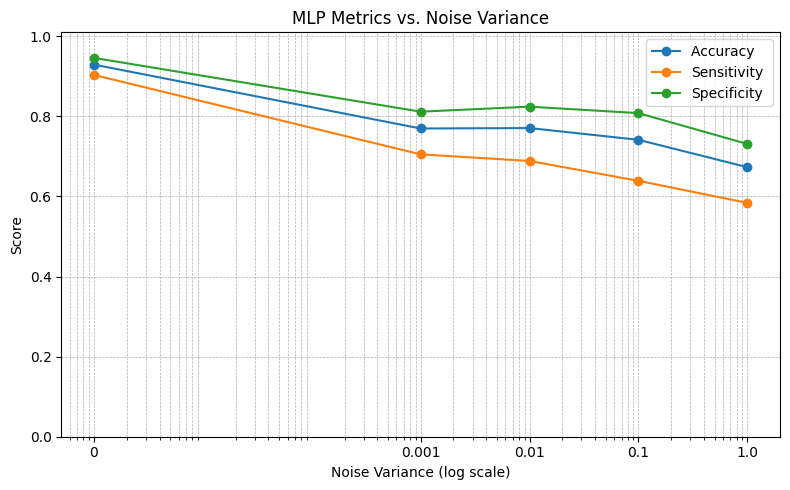

In [80]:
# mlp metrics for each noise variance

# Add base case metrics (noise = 0)
metric_results_mlp_noise = {}
metric_results_mlp_noise[0.0] = {
    "Accuracy   ": accuracies[2],
    "Sensitivity": sensitivities[2],
    "Specificity": specificities[2]
}

# Process noisy predictions
for var, (y_true_tensor, y_pred_tensor) in y_preds_mlp_noise.items():
    tn, fp, fn, tp = confusion_matrix(
        y_true_tensor.cpu().numpy(), y_pred_tensor.cpu().numpy()
    ).ravel()

    metric_results_mlp_noise[var] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }

    print(f"MLP Metrics for noise variance = {var}")
    for key, value in metric_results_mlp_noise[var].items():
        print(f"{key}: {value:.4f}")
    print(" ")

# Prepare for plotting
vars_sorted = sorted(metric_results_mlp_noise.keys())
plot_vars = [1e-6 if v == 0.0 else v for v in vars_sorted]
xtick_labels = ['0' if v == 1e-6 else str(v) for v in plot_vars]

metrics = ["Accuracy   ", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
for metric in metrics:
    values = [metric_results_mlp_noise[0.0 if v == 1e-6 else v][metric] for v in plot_vars]
    plt.plot(plot_vars, values, marker='o', label=metric)

plt.xscale("log")
plt.title("MLP Metrics vs. Noise Variance")
plt.xlabel("Noise Variance (log scale)")
plt.ylabel("Score")
plt.ylim(0.0, 1.01)
plt.xticks(plot_vars, xtick_labels)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [44]:
'''
Apply a feature selection method to select features, and then use the selected features
to train three classifiers.
'''

# feature selection using SelectKBest with ANOVA F-value
#add base case
data_by_noise[0.0] = (X_train_scaled, X_test_scaled, y_train, y_test)
data_by_noise_fs = {}
k = 50

for var, (X_train, X_test, y_train, y_test) in sorted(data_by_noise.items()):
    print(f"Applying feature selection for noise variance = {var}")

    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    scaler = StandardScaler()
    X_train_final = scaler.fit_transform(X_train_selected)
    X_test_final = scaler.transform(X_test_selected)

    # Store selected and scaled data
    data_by_noise_fs[var] = (X_train_final, X_test_final, y_train, y_test)


Applying feature selection for noise variance = 0.0
Applying feature selection for noise variance = 0.001
Applying feature selection for noise variance = 0.01
Applying feature selection for noise variance = 0.1
Applying feature selection for noise variance = 1.0


In [49]:
# lrm model on feature selected noisy data 

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Use feature-selected and scaled data by noise level

best_lrms_noise_fs = {}
y_preds_lrm_noise_fs = {}

for var, (X_train, X_test, y_train, y_test) in sorted(data_by_noise_fs.items()):
    print(f"Training feature-selected LRM for noise variance = {var}...")

    lrm = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )

    grid = GridSearchCV(
        lrm,
        param_grid_logreg,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_lrm = grid.best_estimator_
    y_pred = best_lrm.predict(X_test)
    print(f"Hyperparameters for σ² = {var}: {grid.best_params_}")
    best_lrms_noise_fs[var] = best_lrm
    y_preds_lrm_noise_fs[var] = (y_test, y_pred)


Training feature-selected LRM for noise variance = 0.0...
Hyperparameters for σ² = 0.0: {'C': 10, 'l1_ratio': 0.1}
Training feature-selected LRM for noise variance = 0.001...
Hyperparameters for σ² = 0.001: {'C': 10, 'l1_ratio': 0.1}
Training feature-selected LRM for noise variance = 0.01...
Hyperparameters for σ² = 0.01: {'C': 1, 'l1_ratio': 0.1}
Training feature-selected LRM for noise variance = 0.1...
Hyperparameters for σ² = 0.1: {'C': 0.1, 'l1_ratio': 0.1}
Training feature-selected LRM for noise variance = 1.0...
Hyperparameters for σ² = 1.0: {'C': 0.01, 'l1_ratio': 0.1}


Noise Variance = 0.0
  With FS:
    Accuracy   : 0.9305
    Sensitivity: 0.8898
    Specificity: 0.9570
 
Noise Variance = 0.001
  With FS:
    Accuracy   : 0.9229
    Sensitivity: 0.8788
    Specificity: 0.9516
 
Noise Variance = 0.01
  With FS:
    Accuracy   : 0.9262
    Sensitivity: 0.8926
    Specificity: 0.9480
 
Noise Variance = 0.1
  With FS:
    Accuracy   : 0.8871
    Sensitivity: 0.8320
    Specificity: 0.9229
 
Noise Variance = 1.0
  With FS:
    Accuracy   : 0.8154
    Sensitivity: 0.6804
    Specificity: 0.9032
 


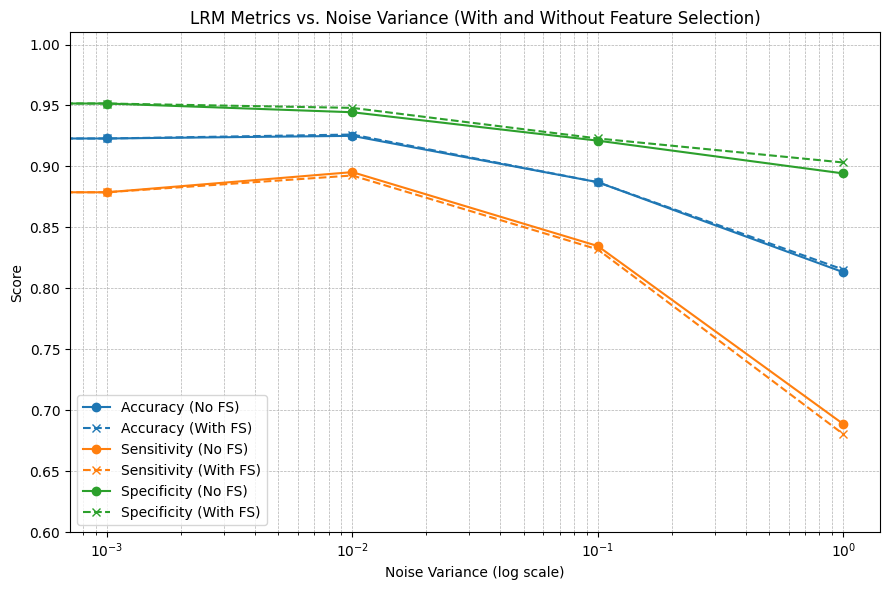

In [58]:
# Plot LRM: With vs Without Feature Selection (Noise Variance)

metrics4 = ["Accuracy   ", "Sensitivity", "Specificity"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Compute metrics for LRM with FEATURE SELECTION
metric_results_lrm_noise_fs = {}

for var, (y_true, y_pred) in y_preds_lrm_noise_fs.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metric_results_lrm_noise_fs[var] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }


plt.figure(figsize=(9, 6))

noise_values_fs = sorted(metric_results_lrm_noise_fs.keys())    

for i, metric in enumerate(metrics4):
    # Extract values for both FS and no-FS
    values_fs = [metric_results_lrm_noise_fs[var][metric] for var in noise_values_fs]
    values_raw = [metric_results_lrm_noise[var][metric] for var in noise_values_fs]

    # Plot both
    plt.plot(noise_values_fs, values_raw, marker='o', label=f"{metric.strip()} (No FS)", color=colors[i])
    plt.plot(noise_values_fs, values_fs, marker='x', linestyle='--', label=f"{metric.strip()} (With FS)", color=colors[i])
for var in noise_values_fs:
    print(f"Noise Variance = {var}")
    print("  With FS:")
    for key, value in metric_results_lrm_noise_fs[var].items():
        print(f"    {key}: {value:.4f}")
    print(" ")
plt.title("LRM Metrics vs. Noise Variance (With and Without Feature Selection)")
plt.xlabel("Noise Variance (log scale)")
plt.ylabel("Score")
plt.xscale("log")
plt.ylim(.6, 1.01)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()



In [57]:
# svm model with FEATURE SELECTED noisy data

# SVM hyperparameter grid
param_grid_svm = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
]

# Store best models and predictions by noise level
best_svms_by_noise_fs = {}
y_preds_svm_by_noise_fs = {}

for var, (X_train, X_test, y_train, y_test) in sorted(data_by_noise_fs.items()):
    print(f"Training SVM for noise variance = {var}...")

    svm = SVC(max_iter=50000, tol=1e-3)

    grid = GridSearchCV(
        svm,
        param_grid_svm,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_svm = grid.best_estimator_
    y_pred = best_svm.predict(X_test)
    print(f"Best hyperparameters for σ² = {var}: {grid.best_params_}")
    best_svms_by_noise_fs[var] = best_svm
    y_preds_svm_by_noise_fs[var] = (y_test, y_pred)

    print(f"Finished training for σ² = {var}\n")

Training SVM for noise variance = 0.0...
Best hyperparameters for σ² = 0.0: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Finished training for σ² = 0.0

Training SVM for noise variance = 0.001...
Best hyperparameters for σ² = 0.001: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Finished training for σ² = 0.001

Training SVM for noise variance = 0.01...
Best hyperparameters for σ² = 0.01: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Finished training for σ² = 0.01

Training SVM for noise variance = 0.1...
Best hyperparameters for σ² = 0.1: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Finished training for σ² = 0.1

Training SVM for noise variance = 1.0...
Best hyperparameters for σ² = 1.0: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Finished training for σ² = 1.0



Noise Variance = 0.0
  With FS:
    Accuracy   : 0.9121
    Sensitivity: 0.8623
    Specificity: 0.9444
 
Noise Variance = 0.001
  With FS:
    Accuracy   : 0.9251
    Sensitivity: 0.8788
    Specificity: 0.9552
 
Noise Variance = 0.01
  With FS:
    Accuracy   : 0.9175
    Sensitivity: 0.8678
    Specificity: 0.9498
 
Noise Variance = 0.1
  With FS:
    Accuracy   : 0.9045
    Sensitivity: 0.8375
    Specificity: 0.9480
 
Noise Variance = 1.0
  With FS:
    Accuracy   : 0.8274
    Sensitivity: 0.7080
    Specificity: 0.9050
 


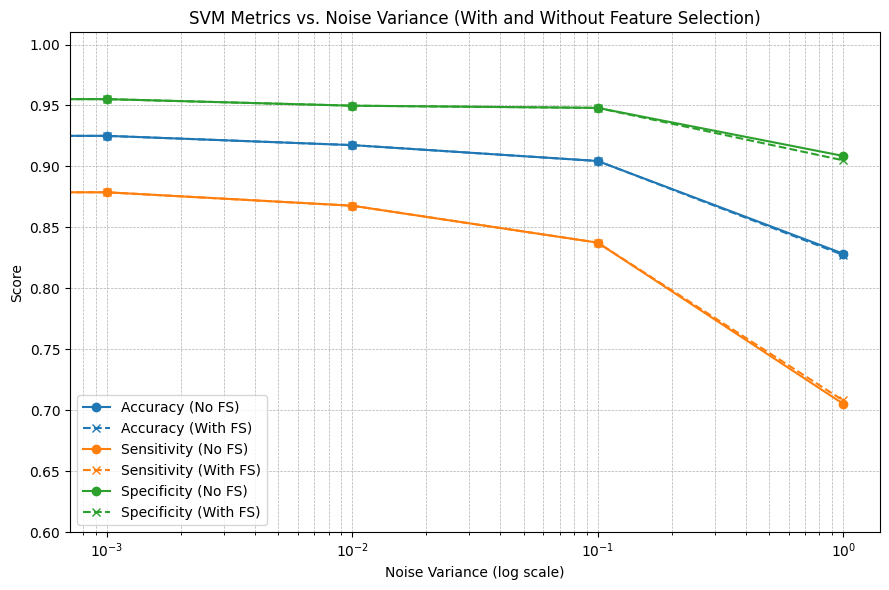

In [62]:
# displaying nosiy fs svm metrics

metrics4 = ["Accuracy   ", "Sensitivity", "Specificity"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Compute metrics for SVM with FEATURE SELECTION
metric_results_svm_noise_fs = {}

for var, (y_true, y_pred) in y_preds_svm_by_noise_fs.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metric_results_svm_noise_fs[var] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }


plt.figure(figsize=(9, 6))

noise_values_fs = sorted(metric_results_svm_noise_fs.keys())    

for i, metric in enumerate(metrics4):
    # Extract values for both FS and no-FS
    values_fs = [metric_results_svm_noise_fs[var][metric] for var in noise_values_fs]
    values_raw = [metric_results_svm_noise[var][metric] for var in noise_values_fs]

    # Plot both
    plt.plot(noise_values_fs, values_raw, marker='o', label=f"{metric.strip()} (No FS)", color=colors[i])
    plt.plot(noise_values_fs, values_fs, marker='x', linestyle='--', label=f"{metric.strip()} (With FS)", color=colors[i])
for var in noise_values_fs:
    print(f"Noise Variance = {var}")
    print("  With FS:")
    for key, value in metric_results_svm_noise_fs[var].items():
        print(f"    {key}: {value:.4f}")
    print(" ")
plt.title("SVM Metrics vs. Noise Variance (With and Without Feature Selection)")
plt.xlabel("Noise Variance (log scale)")
plt.ylabel("Score")
plt.xscale("log")
plt.ylim(.6, 1.01)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
# mlp model with FEATURE SELECTED noisy data

# seed for reproducibility
SEED = 42
seed_everything(SEED)

best_mlps_noise = {}
y_preds_mlp_noise_fs = {}

# Hyperparameter grids
hidden_layer_sizes = [(32, 16), (64, 32), (128, 64)]
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0, 1e-4, 1e-5]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Assume data_by_noise contains standardized + noise-added sets for σ² in [0.001, 0.01, 0.1, 1.0]
# Format: data_by_noise[variance] = (X_train_np, X_test_np, y_train, y_test)

for var, (X_train_np, X_test_np, y_train_np, y_test_np) in sorted(data_by_noise_fs.items()):
    print(f"Training MLP for noise variance σ² = {var}")

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.float32)

    best_score = 0
    best_hparams = None

    for (hidden1, hidden2), lr, wd in product(hidden_layer_sizes, learning_rates, weight_decays):
        fold_scores = []

        for train_idx, val_idx in kf.split(X_train_tensor):
            seed_everything(SEED)
            model = MLP(X_train_tensor.shape[1], hidden1, hidden2)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = nn.BCEWithLogitsLoss()

            X_train_fold = X_train_tensor[train_idx]
            y_train_fold = y_train_tensor[train_idx]
            X_val_fold = X_train_tensor[val_idx]
            y_val_fold = y_train_tensor[val_idx]

            model.train()
            for epoch in range(20):
                optimizer.zero_grad()
                output = model(X_train_fold).squeeze()
                loss = criterion(output, y_train_fold)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_fold).squeeze()
                val_probs = torch.sigmoid(val_output)
                val_preds = (val_probs > 0.5).float()
                acc = (val_preds == y_val_fold).float().mean().item()
                fold_scores.append(acc)

        avg_score = sum(fold_scores) / len(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_hparams = (hidden1, hidden2, lr, wd)

    # Final model training with best hyperparams
    best_hidden1, best_hidden2, best_lr, best_wd = best_hparams
    seed_everything(SEED)
    best_mlp = MLP(X_train_tensor.shape[1], best_hidden1, best_hidden2)
    optimizer = optim.Adam(best_mlp.parameters(), lr=best_lr, weight_decay=best_wd)
    criterion = nn.BCEWithLogitsLoss()

    best_mlp.train()
    for epoch in range(90):
        optimizer.zero_grad()
        output = best_mlp(X_train_tensor).squeeze()
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    best_mlp.eval()
    with torch.no_grad():
        test_output = best_mlp(X_test_tensor).squeeze()
        test_probs = torch.sigmoid(test_output)
        y_pred_mlp = (test_probs > 0.5).float()

    best_mlps_noise[var] = best_mlp
    y_preds_mlp_noise_fs[var] = (y_test_tensor, y_pred_mlp)

    print(f"Best hyperparams for σ² = {var}: hidden=({best_hidden1}, {best_hidden2}), lr={best_lr}, weight_decay={best_wd}\n")


Training MLP for noise variance σ² = 0.0
Best hyperparams for σ² = 0.0: hidden=(128, 64), lr=0.01, weight_decay=0

Training MLP for noise variance σ² = 0.001
Best hyperparams for σ² = 0.001: hidden=(128, 64), lr=0.01, weight_decay=0.0001

Training MLP for noise variance σ² = 0.01
Best hyperparams for σ² = 0.01: hidden=(128, 64), lr=0.01, weight_decay=1e-05

Training MLP for noise variance σ² = 0.1
Best hyperparams for σ² = 0.1: hidden=(128, 64), lr=0.01, weight_decay=0.0001

Training MLP for noise variance σ² = 1.0
Best hyperparams for σ² = 1.0: hidden=(128, 64), lr=0.01, weight_decay=0



Keys in metric_results_mlp_noise: dict_keys([0.0, 0.001, 0.01, 0.1, 1.0])
Keys in metric_results_mlp_noise_fs: dict_keys([0.0, 0.001, 0.01, 0.1, 1.0])
Noise Variance = 0.0
  With FS:
    Accuracy   : 0.9121
    Sensitivity: 0.8623
    Specificity: 0.9444
 
Noise Variance = 0.001
  With FS:
    Accuracy   : 0.9251
    Sensitivity: 0.8788
    Specificity: 0.9552
 
Noise Variance = 0.01
  With FS:
    Accuracy   : 0.9175
    Sensitivity: 0.8678
    Specificity: 0.9498
 
Noise Variance = 0.1
  With FS:
    Accuracy   : 0.9045
    Sensitivity: 0.8375
    Specificity: 0.9480
 
Noise Variance = 1.0
  With FS:
    Accuracy   : 0.8274
    Sensitivity: 0.7080
    Specificity: 0.9050
 


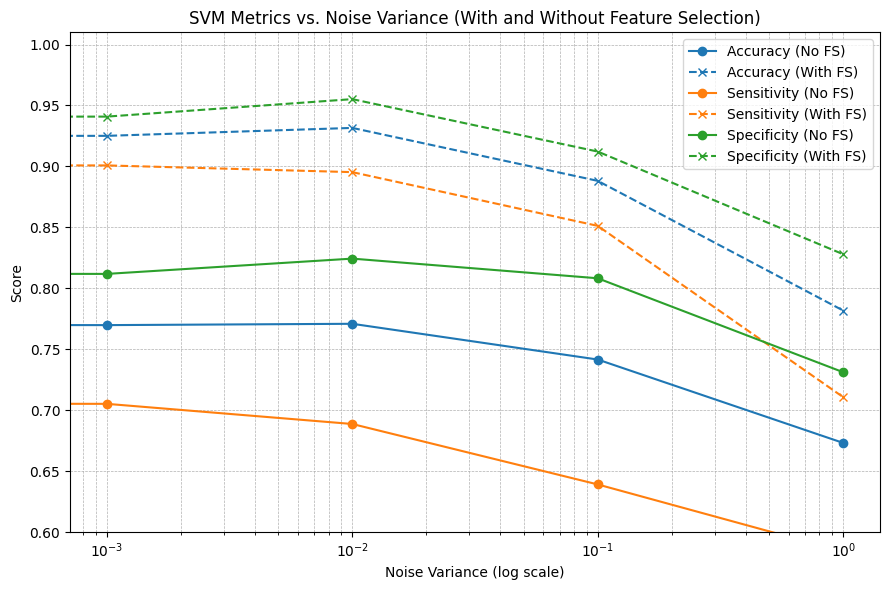

In [71]:
# displaying noisy fs mlp metrics

metrics4 = ["Accuracy   ", "Sensitivity", "Specificity"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Compute metrics for mlp with FEATURE SELECTION
metric_results_mlp_noise_fs = {}

for var, (y_true, y_pred) in y_preds_mlp_noise_fs.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metric_results_mlp_noise_fs[var] = {
        "Accuracy   ": accuracy(tn, fp, fn, tp),
        "Sensitivity": sensitivity(tp, fn),
        "Specificity": specificity(tn, fp)
    }


plt.figure(figsize=(9, 6))

print("Keys in metric_results_mlp_noise:", metric_results_mlp_noise.keys())
print("Keys in metric_results_mlp_noise_fs:", metric_results_mlp_noise_fs.keys())


noise_values_fs = sorted(metric_results_mlp_noise_fs.keys())    

for i, metric in enumerate(metrics4):
    # Extract values for both FS and no-FS
    values_fs = [metric_results_mlp_noise_fs[var][metric] for var in noise_values_fs]
    values_raw = [metric_results_mlp_noise[var][metric] for var in noise_values_fs]

    # Plot both
    plt.plot(noise_values_fs, values_raw, marker='o', label=f"{metric.strip()} (No FS)", color=colors[i])
    plt.plot(noise_values_fs, values_fs, marker='x', linestyle='--', label=f"{metric.strip()} (With FS)", color=colors[i])
for var in noise_values_fs:
    print(f"Noise Variance = {var}")
    print("  With FS:")
    for key, value in metric_results_svm_noise_fs[var].items():
        print(f"    {key}: {value:.4f}")
    print(" ")
plt.title("SVM Metrics vs. Noise Variance (With and Without Feature Selection)")
plt.xlabel("Noise Variance (log scale)")
plt.ylabel("Score")
plt.xscale("log")
plt.ylim(.6, 1.01)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

If you made it this far, thank you for reading! Dr. Cai, this was a great class, and I enjoyed conducting this investigation - messy as this notebook is, I plan to convert it sometime over the summer to a cleaner format.